In [1]:
import numpy as np
from skimage import io
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.filters import threshold_niblack
from skimage.filters import threshold_sauvola
from skimage import measure, segmentation, morphology
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import data
from scipy.stats import kurtosis
from skimage import color, morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from scipy import stats
from copy import deepcopy
import os

In [2]:
image_file = '200929_LBT001_5dpi_Pos006.tiff' 
img = io.imread(image_file) ###read the image
image_final = np.zeros(img.shape)
no_af_image = np.zeros((img.shape[1], img.shape[2], img.shape[3], img.shape[4]))
print(img.shape)

(12, 149, 1024, 1024, 3)


In [3]:
im_tumor = img[:,:,:,:,0] ###assign first channel to tumor
im_macrophages = img[:,:,:,:,1] ###assign second channel to tmacrophages
im_vessel = img[:,:,:,:,2] ###assign third channel to vessel

In [32]:
print(im_tumor.shape)

(12, 149, 1024, 1024)


In [ ]:
for tscale in range(img.shape[0]):
    img_tumor = im_tumor[tscale]
    img_macro = im_macrophages[tscale]
    img_vessel = im_vessel[tscale]

    gauss_filt1 = gaussian(img_tumor, sigma=2)
    thresh1 = threshold_otsu(gauss_filt1, 31)
    binary1 = gauss_filt1 > thresh1

    gauss_filt2 = gaussian(img_macro, sigma=2)
    thresh2 = threshold_otsu(gauss_filt2, 31)
    binary2 = gauss_filt2 > thresh2

    intersection_img = binary1 * binary2


    label_img_list, rp_list = [], []
    for i in range(intersection_img.shape[0]):
        label_img = label(intersection_img[i])
        rp = regionprops_table(label_img, properties=['area', 'label', 'coords'])
        label_img_list.append(label_img)
        rp_list.append(rp)

    label_ok, coords_ok, area_ok = [], [], []
    for i in range(len(label_img_list)):
        temp_label, temp_coords, temp_area = [], [], []
        for idx, area in enumerate(rp_list[i]['area']):
            if area > 20 and area < 10000:
                temp_label.append((rp_list[i]['label'][idx]))
                temp_coords.append(rp_list[i]['coords'][idx])
                temp_area.append(rp_list[i]['area'][idx])
        label_ok.append(temp_label)
        coords_ok.append(temp_coords)
        area_ok.append(temp_area)

    tumor_mask_pix, macro_mask_pix, vessel_mask_pix = [], [], []

    def extract_pixel(image, coords):
        pixels = np.zeros(len(coords))
        for idx, c in enumerate(coords):
            pixels[idx] = image[c[0], c[1]]
        return pixels

    for i in range(len(coords_ok)):
        temp_tumor_pix, temp_macro_pix, temp_vessel_pix = [], [], []
        for coords in coords_ok[i]:
            temp_tumor_pix.append(extract_pixel(img_tumor[i], coords))
            temp_macro_pix.append(extract_pixel(img_macro[i], coords))
            temp_vessel_pix.append(extract_pixel(img_vessel[i], coords))
        tumor_mask_pix.append(temp_tumor_pix)
        macro_mask_pix.append(temp_macro_pix)
        vessel_mask_pix.append(temp_vessel_pix)

    corrval_tm = []
    for zscale in range(len(label_img_list)):
        temp_corr = np.zeros(len(coords_ok[zscale]))
        for j in range(len(coords_ok[zscale])):
            _, temp_corr[j] = np.corrcoef(tumor_mask_pix[zscale][j], macro_mask_pix[zscale][j])[0]
        corrval_tm.append(temp_corr)

    def remove_artifact_one_zscale(zscale, img_tumor, img_vessel, img_macro, corrval_tm, coords_ok):
        corrcutoff = 0.5
        corrAF = corrval_tm[zscale] > corrcutoff
        #print(corrAF)
        #print(label_ok[zscale])
        coords_af = []
        for i, c in enumerate(coords_ok[zscale]):
            if corrAF[i]:
                coords_af.append(coords_ok[zscale][i])
        #print(label_af)
        tumor_ohne_af, macro_ohne_af, vessel_ohne_af = deepcopy(img_tumor[zscale]), deepcopy(img_macro[zscale]), deepcopy(img_vessel[zscale])
        #print(coords_af)
        for coords in coords_af:
            for c in coords:
                tumor_ohne_af[c[0], c[1]] = 0
                vessel_ohne_af[c[0], c[1]] = 0
                macro_ohne_af[c[0], c[1]] = 0
        return tumor_ohne_af, vessel_ohne_af, macro_ohne_af

    tumor_no_af, vessel_no_af, macro_no_af = np.zeros_like(img_tumor), np.zeros_like(img_vessel), np.zeros_like(img_macro)
    for zscale in range(img_tumor.shape[0]):
        tumor_no_af[zscale], vessel_no_af[zscale], macro_no_af[zscale] = remove_artifact_one_zscale(zscale, img_tumor, img_vessel, img_macro, corrval_tm, coords_ok)
        
        no_af_image[zscale,:,:,0] = tumor_no_af[zscale]
        no_af_image[zscale,:,:,1] = macro_no_af[zscale]
        no_af_image[zscale,:,:,2] = vessel_no_af[zscale]
    
    image_final[tscale] = no_af_image

In [5]:
print(image_final.shape)

(12, 149, 1024, 1024, 3)


In [16]:
print("diff", np.linalg.norm(image_final[1,1,:,:,0].ravel() - img[1,1,:,:,0].ravel()))
image_final[1,1,:,:,1]

diff 345.059415173677


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

diff 2180.794579963918


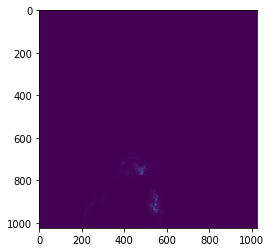

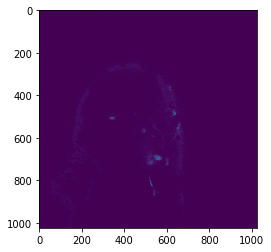

In [14]:
print("diff", np.linalg.norm(image_final[1,1,:,:,0].ravel() - tumor_no_af[1].ravel()))
plt.imshow(image_final[1,1,:,:,0])
plt.show()
plt.imshow(tumor_no_af[1])